# 2.2 Tsiveriotis-Fernandes 기반 Valuation
last updated : 2023-06-30

Tsiveriotis-Fernandes 모형을 활용한 CB 및 RCPS Valaution 을 수행한다. 
단,본실습은 기초자산, 이자율 등 필요 변수들을 설명의 편의상 앞선 엑셀실습과 동일하게 정의하였다.

### input 정의
- s : 기초자산
- rf : 무위험이자율
- kd : 위험이자율
- volatility : 변동성
- t : 만기
- x : 행사가액
- put_ytm : put만기수익률
- u : 상승확률
- d : 하락확률
- p : 위험중립확률 ( p )
- q : 위험중립확률 ( q )

In [1]:
import numpy as np
import pandas as pd

# Input 
node_count = 11
s = 100000
x = 100000
put_yield = 0.05
rf = 0.015 
kd = 0.05 # 위험이자율, 편의를 위하여 Forward는 
volatility = 0.255
delta_t = 1
u = np.exp(volatility* np.sqrt(delta_t)) # 
d = 1 / u
p = (np.exp(rf * delta_t) - d) / (u - d)
q = 1 - p

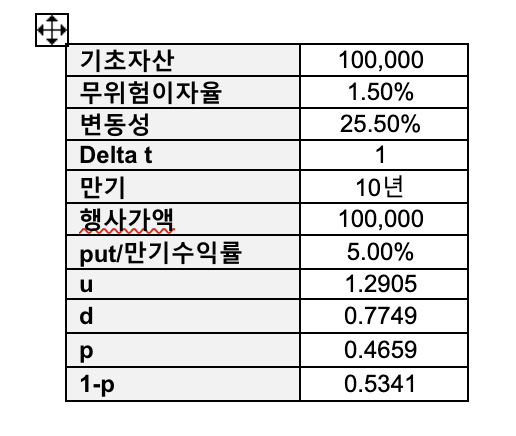

### Step 1: 날짜 배열 생성

In [2]:
# 편의상 노드는 현재시점 ~ 10년까지 총 11개 노드로 구성

node_array = arr = np.arange(0, node_count)
print(node_array)

# 출력 : [ 0  1  2  3  4  5  6  7  8  9 10]

[ 0  1  2  3  4  5  6  7  8  9 10]


### Step 2: 부트스트래핑을 사용하여 kd 및 rf spot rate 및 forward rate 계산

In [3]:
kd_forward_array = kd + 0.0001 * node_array

kd_forward_array
print(kd_forward_array)
# 출력 : [0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059]

[0.05   0.0501 0.0502 0.0503 0.0504 0.0505 0.0506 0.0507 0.0508 0.0509
 0.051 ]


### Step 3: 상환전환우선주 상환금액 트리 생성 (주계약/put)

In [4]:
# 행사가액 x ( 1 + put 이자율) ^ 각 시점별 제곱
put_ammount_array = x * np.power((1+put_yield), node_array)

print(put_ammount_array)
# 출력 : 
"""
[100000.         105000.         110250.         115762.5
 121550.625      127628.15625    134009.5640625  140710.04226563
 147745.54437891 155132.82159785 162889.46267774]
"""


# 가장 뒤에있는 상환가능금액에서 해당 시점에 해당하는 kd_forward_rate를 고려하여 상환가능금액에서 채권의 가치를 산출합니다.

# put_ammount_array와 동일한 크기의 bond_array를 만든다.
bond_array = np.zeros_like(put_ammount_array)
# 가장 마지막 가치는 bond_array와 put_ammount_array가 동일합니다. 
bond_array[-1] = put_ammount_array[-1]

# 마지막번째에서 1개 노드 하나 앞에부터 for-loop 생성
for i in reversed(range(node_count-1)):
    bond_array[i] = bond_array[i+1] / (1 + kd_forward_array[i+1])
    
print(bond_array)

#출력 : 

"""
[ 99477.73357059 104461.56802248 109705.53873721 115223.72733569
121031.00319341 127143.06885468 133576.50813872 140348.83710136
147478.5580261  154985.21662963 162889.46267774]
"""

[100000.         105000.         110250.         115762.5
 121550.625      127628.15625    134009.5640625  140710.04226563
 147745.54437891 155132.82159785 162889.46267774]
[ 99477.73357059 104461.56802248 109705.53873721 115223.72733569
 121031.00319341 127143.06885468 133576.50813872 140348.83710136
 147478.5580261  154985.21662963 162889.46267774]


'\n[ 99477.73357059 104461.56802248 109705.53873721 115223.72733569\n121031.00319341 127143.06885468 133576.50813872 140348.83710136\n147478.5580261  154985.21662963 162889.46267774]\n'

### Step 4: 주가 이항 트리 생성


In [5]:
# 노드개수만큼의 0으로 이루어진, n x n 행렬생성 
stock_binomial_tree = np.zeros((node_count, node_count))

# 가장 첫번째 노드에 기초자산주가 설정
stock_binomial_tree[0, 0] = s

# 2번째 노드부터 마지막 노드까지 순차적으로 실행되는 for-loop 실행
for i in range(1, node_count):
    # 상승노드의 경우, 상승계수만 반영
    stock_binomial_tree[0, i] = stock_binomial_tree[0, i-1] * u
    # 하락노드
    stock_binomial_tree[1:i+1, i] = stock_binomial_tree[:i, i-1] * d


# 11 x 11 배열 중, 앞 3 x 3 배열만 보여줌
print(stock_binomial_tree[:3, :3])

# 출력 : 
"""
[[100000.         129046.16208729 166529.11949459]
 [     0.          77491.64979611 100000.        ]
 [     0.              0.          60049.55788123]]
"""

[[100000.         129046.16208729 166529.11949459]
 [     0.          77491.64979611 100000.        ]
 [     0.              0.          60049.55788123]]


'\n[[100000.         129046.16208729 166529.11949459]\n [     0.          77491.64979611 100000.        ]\n [     0.              0.          60049.55788123]]\n'

### Step 5: TF Valuation

In [6]:
# decision_tee : 의사결정트리 
# tf_value_tree : tf 가치트리 
# equity_value_tree : equity 가치트리 
# debt_value_tree : debt 가치트리
# equity_holding_value_tree : equity 보유가치트리 
# debt_holding_value_tree : debt 보유가치트리
# holding_value_tree : equity + debt 보유가치트리

decision_tree = np.zeros_like(stock_binomial_tree)
tf_value_tree = np.zeros_like(stock_binomial_tree)
equity_value_tree = np.zeros_like(stock_binomial_tree)
debt_value_tree = np.zeros_like(stock_binomial_tree)

equity_holding_value_tree = np.zeros_like(stock_binomial_tree) 
debt_holding_value_tree = np.zeros_like(stock_binomial_tree)
holding_value_tree = np.zeros_like(stock_binomial_tree)

In [7]:
# 가장 마지막 시점의 값을 업데이트 
# max(전환가치, 부채가치)
tf_value_tree[:, -1] = np.maximum(stock_binomial_tree[:, -1], bond_array[-1])


In [8]:
tf_value_tree[:, -1]
# 출력 
"""
array([1280710.3782663 ,  769060.9198879 ,  461817.68222998,
        277319.47639643,  166529.11949459,  162889.46267774,
        162889.46267774,  162889.46267774,  162889.46267774,
        162889.46267774,  162889.46267774])
"""

'\narray([1280710.3782663 ,  769060.9198879 ,  461817.68222998,\n        277319.47639643,  166529.11949459,  162889.46267774,\n        162889.46267774,  162889.46267774,  162889.46267774,\n        162889.46267774,  162889.46267774])\n'

In [9]:
equity_value_tree[:,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
# 가장 마지막 값이 전환트리랑 똑같다면, 1, 아니면 0
decision_tree[:, -1] = np.where(tf_value_tree[:, -1]== stock_binomial_tree[:, -1], 1, 0)


In [11]:
# 만약, decision_tree 값이 1인 경우, equity_value 값은 주식가치 그렇지 않은 경우 0
# 만약, decision_tree 값이 0인 경우, debt_value 값은 부채가치 그렇지 않은 경우 0
equity_value_tree[:, -1] = np.where(decision_tree[:, -1] == 1, stock_binomial_tree[:, -1],0)
debt_value_tree[:, -1] = np.where(decision_tree[:, -1] == 0, bond_array[-1],0)

In [12]:
# 가장 마지막 열의 전부터 첫번째 열까지 역방향으로 업데이트를 해야하므로, 역순으로 반복문을 돌린다.
for t in reversed(range(tf_value_tree.shape[1] - 1)):

    # # t시점의 equity_holding_value, debt_holding_value, holding_value를 업데이트한다.

    equity_holding_value_tree[:t+1, t] = (equity_value_tree[:t+1, t+1] * p + equity_value_tree[1:t+2, t+1] * q) * np.exp(-rf)    
    debt_holding_value_tree[:t+1, t] = (debt_value_tree[:t+1, t+1] * p + debt_value_tree[1:t+2, t+1] * q) *  np.exp(-kd_forward_array[t+1])
    holding_value_tree[:t+1, t] = equity_holding_value_tree[:t+1, t] + debt_holding_value_tree[:t+1, t]
    
    # t시점의 rcps value를 업데이트한다.
    tf_value_tree[:t+1, t] = np.maximum(np.maximum(bond_array[t], np.maximum(stock_binomial_tree[:t+1, t], put_ammount_array[t])), holding_value_tree[:t+1, t])

    # t시점의 rcps value로 부터 상환 전환 보유 의사결정을 업데이트한다.
    # 만약, t시점의 rcps value가 전환가치와 동일하다면 의사결정트리를 전환으로, 상환가치와 동일하다면 의사결정트리를 상환으로, 그 외의 경우에는 보유로 판단한다.

    decision_tree[:t+1, t] = np.where(tf_value_tree[:t+1, t] <= stock_binomial_tree[:t+1, t], 1,
                                        np.where(tf_value_tree[:t+1, t] <= put_ammount_array[t], 0, 0.5))

    # 의사결정트리에 따른 equity_value, debt_value를 업데이트한다.

    equity_value_tree[:t+1, t] = np.where(decision_tree[:t+1, t] == 1, stock_binomial_tree[:t+1, t],
                                            np.where(decision_tree[:t+1, t] == 0, 0, equity_value_tree[:t+1, t+1] * p + equity_value_tree[1:t+2, t+1] * q) * np.exp(-rf))
    debt_value_tree[:t+1, t] = np.where(decision_tree[:t+1, t] == 1, 0,
                                        np.where(decision_tree[:t+1, t] == 0, put_ammount_array[t], debt_holding_value_tree[:t+1, t]))


In [13]:
tf_value_tree

array([[ 130795.05145036,  153006.71324544,  183489.71593393,
         225307.01763159,  282336.65547296,  359329.39600887,
         461817.68222998,  595957.99475826,  769060.9198879 ,
         992443.60122853, 1280710.3782663 ],
       [      0.        ,  119842.36654137,  134862.3125377 ,
         155474.86632153,  184175.63892591,  224357.00101818,
         280471.22219645,  357870.14101016,  461817.68222998,
         595957.99475826,  769060.9198879 ],
       [      0.        ,       0.        ,  115862.18356693,
         125972.88803645,  139342.00829078,  157721.20599455,
         183784.650934  ,  221636.8241136 ,  277319.47639643,
         357870.14101016,  461817.68222998],
       [      0.        ,       0.        ,       0.        ,
         117034.38757074,  124362.74560187,  133193.9403185 ,
         144364.21545926,  159322.2978271 ,  180810.13643263,
         214899.43746552,  277319.47639643],
       [      0.        ,       0.        ,       0.        ,
              

### Step 6: 엑셀로 결과물뽑기
위 코드를 엑셀과 같이 확인하기 위한 작업이다. 눈으로 직접 보면서, 계산을 따라갈 수 있는 엑셀처럼 결과값들을 한눈에 볼 수 있도록 엑셀을 구성한다.

- stock_binomial_tree : 주가이항과정
- put_ammount_array : 상환가능금액
- bond_array : 사채가치
- decision_tee : 의사결정트리 
- equity_value_tree : equity 가치트리 
- debt_value_tree : debt 가치트리
- equity_holding_value_tree : equity 보유가치트리 
- debt_holding_value_tree : debt 보유가치트리
- holding_value_tree : equity + debt 보유가치트리
- tf_value_tree : tf 가치트리 

In [14]:
excel_data = {
"stock_binomial_tree" : stock_binomial_tree,
"put_ammount_array" : put_ammount_array,
"bond_array" : bond_array,
"decision_tree" : decision_tree,
"equity_value_tree" : equity_value_tree,
"debt_value_tree" : debt_value_tree,
"equity_holding_value_tree" : equity_holding_value_tree,
"debt_holding_value_tree" : debt_holding_value_tree,
"holding_value_tree" : holding_value_tree,
"tf_value_tree" : tf_value_tree,
}

excel_path = "Ch2.2_Tsiveriotis-Fernandes.xlsx"

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    # 데이터프레임을 엑셀 파일에 저장할 때, 시트 이름을 지정하여 새로운 시트를 추가합니다.
    for key in excel_data.keys():
        result_df = pd.DataFrame(excel_data[key])
        result_df.to_excel(
            writer, sheet_name=key, index=True)
